Please create a folder named `data` in the main directory and place the following files inside it:

- `Reddit-Threads_2020-2021.csv`
- `Reddit-Threads_2022-2023.csv`

In [1]:
import pandas as pd
import ast
import torch
import torch.nn as nn
import transformers
from transformers import pipeline
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import requests
import os
from dotenv import load_dotenv
import time
from huggingface_hub import login
import google.generativeai as genai
import os
from tqdm import tqdm
from datasets import Dataset
import json
from openai import OpenAI
import numpy as np
from sklearn.metrics import f1_score
import random

if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(torch.cuda.current_device())
    print(f'Device in use: {device_name}')
else:
    device = torch.device("cpu")
    print('Device in use: CPU')

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # If using multi-GPU
    torch.backends.cudnn.deterministic = True  # Make the algorithm deterministic
    torch.backends.cudnn.benchmark = False  # Disable benchmarking for reproducibility

# Call the seed-setting function
set_seed(42)

load_dotenv()

c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device in use: NVIDIA GeForce RTX 3080 Laptop GPU


True

# Reading in data

In [2]:
df = pd.DataFrame()

###   SMALL DATASET   ###
# df = pd.read_csv('data/Reddit-Threads_2020-2021.csv', nrows=10000)
# print(df.head())
###   SMALL DATASET   ###

###   FULL DATASET   ###
# chunk_size = 10000
# for chunk in pd.read_csv('data/Reddit-Threads_2020-2021.csv', chunksize=chunk_size):
#     print(chunk.head())  
#     df = pd.concat([df, chunk])
# for chunk in pd.read_csv('data/Reddit-Threads_2022-2023.csv', chunksize=chunk_size):
#     print(chunk.head())  
#     df = pd.concat([df, chunk])
###   FULL DATASET   ###

###   VALIDATION DATASET   ###
df = pd.read_csv('data/labeled_data_2.csv')
print(df.head())

print(df.shape)


                                                text            timestamp  \
0     Expensive eh now that Uglyfoods closed down :(  2023-01-30 01:04:43   
1                How dare you.. wan go lim kopi ah??  2022-05-04 18:57:57   
2  Yeah the governments can politick all they wan...  2022-06-28 13:44:33   
3               Hijacks event, then complains. Wild.  2022-07-12 07:29:47   
4  Hate to break it to you. But once someone accu...  2023-08-23 02:08:16   

              username                                               link  \
0      MangoDangoLango  /r/singapore/comments/10nqt5h/rsingapore_rando...   
1               900122  /r/SingaporeRaw/comments/ui0rmg/dont_take_offe...   
2  DisillusionedSinkie  /r/singapore/comments/vmb197/malaysias_top_tal...   
3            nehjipain  /r/singapore/comments/vx42x1/nus_student_tried...   
4          KeenStudent  /r/singapore/comments/15ybdme/sorry_doesnt_cut...   

      link_id   parent_id       id subreddit_id  toxic  hateful  ...  \
0 

# Cleaning

In [3]:
# df['moderation'] = df['moderation'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# moderation_dicts = df['moderation']
# moderation_normalized = pd.json_normalize(moderation_dicts)
# # print(moderation_normalized)
# df = df.reset_index(drop=True)
# moderation_normalized = moderation_normalized.reset_index(drop=True)
# df_normalized = pd.concat([df.drop(columns=['moderation']), moderation_normalized], axis=1)
# print(df_normalized.columns)
df_normalized = df

### removing deleted or removed text ###
df_normalized = df_normalized[df_normalized['text'] != '[deleted]']
df_normalized = df_normalized[df_normalized['text'] != '[removed]']
### removing deleted or removed text ###

### stop word removal ###
# stop_words = set(stopwords.words('english'))

# def remove_stop_words(text):
#     if isinstance(text, str):  # Check if the text is a string
#         return ' '.join([word for word in text.split() if word.lower() not in stop_words])
#     return text 

# df_normalized['text'] = df_normalized['text'].apply(remove_stop_words)
# print(df_normalized['text'])
# print(stop_words)
### stop word removal ###

In [4]:
print(df.columns)

Index(['text', 'timestamp', 'username', 'link', 'link_id', 'parent_id', 'id',
       'subreddit_id', 'toxic', 'hateful', 'controversiality',
       'collapsed_reason_code', 'collapsed', 'collapsed_reason',
       'banned_at_utc', 'mod_reason_by', 'mod_reason_title', 'banned_by',
       'num_reports', 'author_is_blocked', 'mod_note', 'report_reasons',
       'mod_reports', 'removal_reason', 'user_reports', 'Llama3_toxic',
       'Llama3_hate', 'BERT_toxic', 'BERT_hateful'],
      dtype='object')


C:\Users\caboo\AppData\Local\Temp\ipykernel_11940\628181459.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Not specified' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_for_plot.fillna('Not specified', inplace=True)


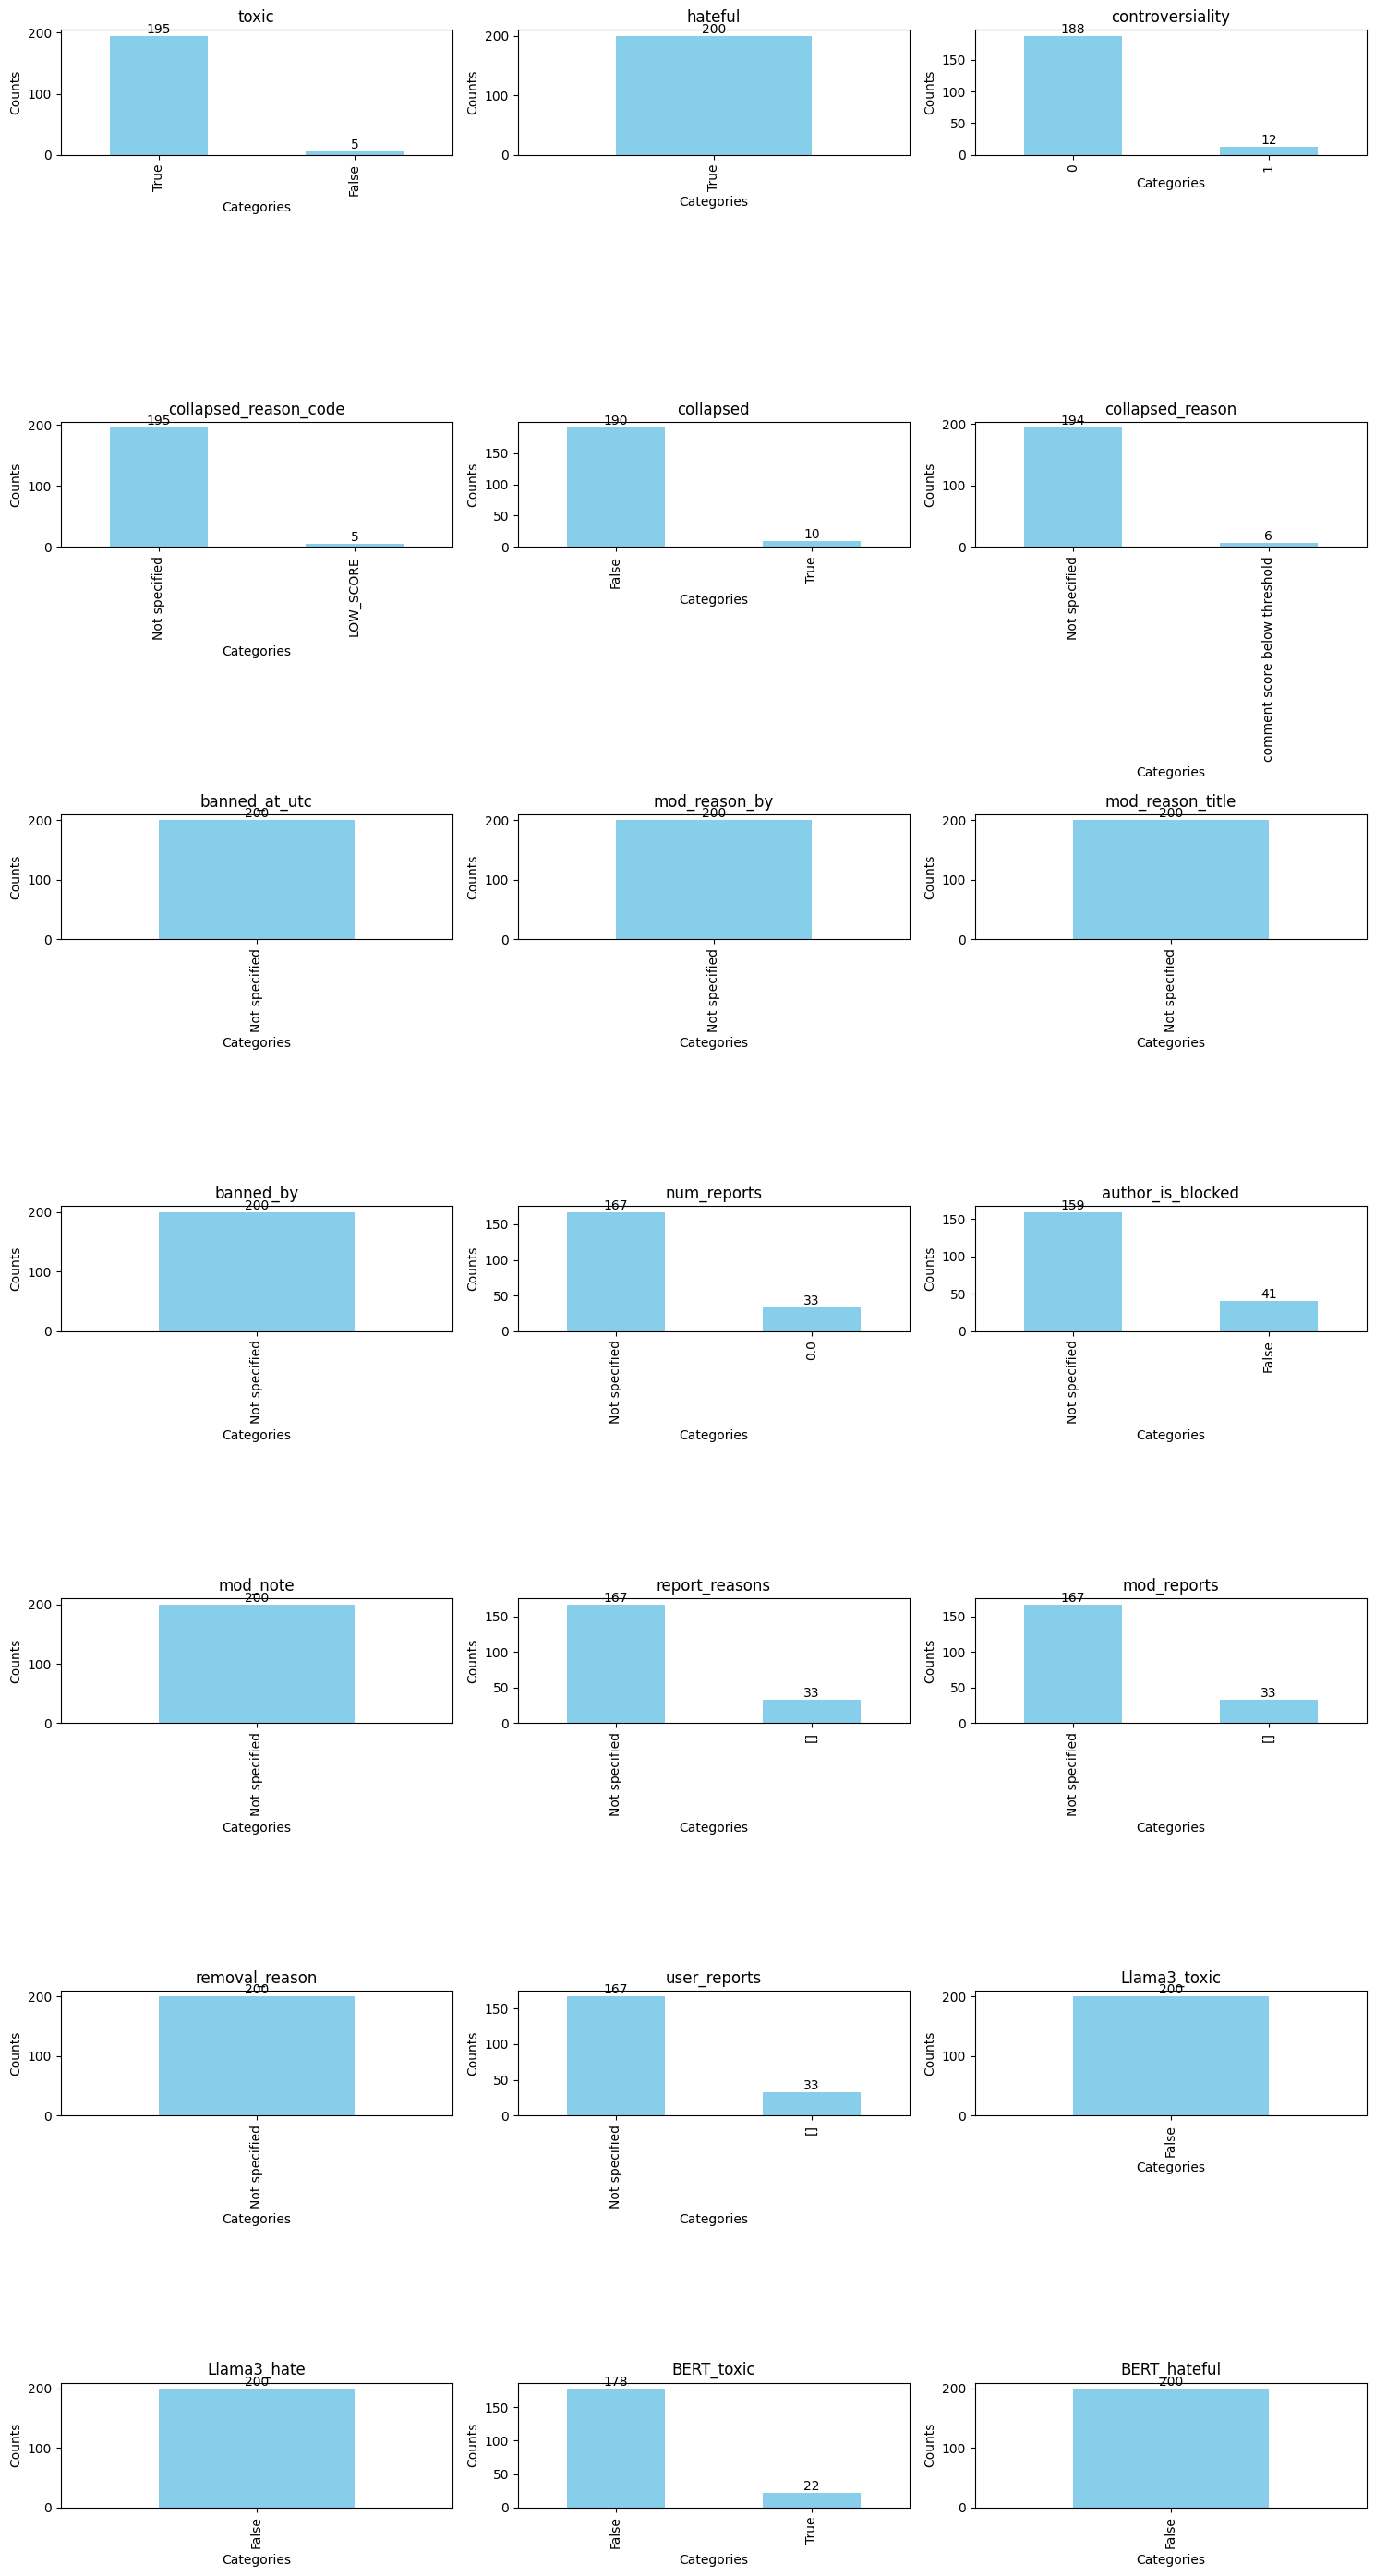

In [5]:
df_for_plot = df_normalized.copy()
df_for_plot.fillna('Not specified', inplace=True)


exclude_columns = [
    'text', 
    'timestamp', 
    'username', 
    'link', 
    'link_id', 
    'parent_id', 
    'id', 
    'subreddit_id'
]
columns_to_plot = [col for col in df_normalized.columns if col not in exclude_columns]


num_columns = len(columns_to_plot)
cols = 3  
rows = (num_columns + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    counts = df_for_plot[column].value_counts()
    if not counts.empty:
        bars = counts.plot(kind='bar', ax=axes[i], color='skyblue')
        axes[i].set_title(column)
        axes[i].set_xlabel('Categories')
        axes[i].set_ylabel('Counts')

        for bar in bars.patches:
            axes[i].annotate(format(int(bar.get_height())), 
                                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                                ha='center', va='bottom')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()

# 2 Using LLMs to label our data

## hugging face login

In [6]:
hf_api_key = os.getenv('HUGGINGFACE_API_KEY')

login(token=hf_api_key)


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\caboo\.cache\huggingface\token
Login successful


In [24]:
def toxic_prompt(text):
    return f"""
<s>[INST] <<SYS>>
You are a moderator on a social media platform. You are reviewing a user's comment to determine if it is toxic. 
Please respond with a number from 0 (not toxic) to 1 (very toxic) for the following comment.
<</SYS>>
Tell me if this text is toxic: {text} [/INST]
"""


def hate_prompt(text):
    return(f"""Give me a score between 0 and 1 of how hateful the text is. Note this is in the singaporean context:

Text: "{text}"
""")




In [26]:
toxic_classifier = pipeline("text-generation", model="meta-llama/Llama-3.2-1B", device=0)
# toxic_classifier.model.eval()

response = toxic_classifier(
    toxic_prompt("I hate you"),
    max_new_tokens=50,
    do_sample=False,
    truncation=True
)

print(response)

del toxic_classifier

c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:606: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


[{'generated_text': "\n<s>[INST] <<SYS>>\nYou are a moderator on a social media platform. You are reviewing a user's comment to determine if it is toxic. \nPlease respond with a number from 0 (not toxic) to 1 (very toxic) for the following comment.\n<</SYS>>\nTell me if this text is toxic: I hate you [/INST]\n"}]


## 2.1 toxic-bert


In [9]:
toxic_classifier = pipeline("text-classification", model="unitary/toxic-bert", return_all_scores=True, device=device)
df_normalized['BERT-toxic'] = False

for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying toxicity"):
    text = row['text']

    try:
        toxic_prediction = toxic_classifier(text)
        for pred in toxic_prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'toxic' and score > 0.5:  # Adjust threshold as needed
                df_normalized.at[index, 'BERT-toxic'] = True
    except RuntimeError as e:
        print(f"Error processing toxicity at index {index}: {e}")

del toxic_classifier
torch.cuda.empty_cache()  

print(df_normalized['BERT_toxic'].value_counts())
toxic_samples = df_normalized[df_normalized['BERT_toxic'] == 1].sample(n=5, random_state=42) 
non_toxic_samples = df_normalized[df_normalized['BERT_toxic'] == 0].sample(n=5, random_state=42)

with pd.option_context('display.max_colwidth', None):
    print("5 Toxic Samples:")
    print(toxic_samples['text'])

    print("\n5 Non-Toxic Samples:")
    print(non_toxic_samples['text'])

c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying toxicity: 100%|██████████| 200/200 [00:03<00:00, 58.34it/s]


BERT_toxic
False    178
True      22
Name: count, dtype: int64
5 Toxic Samples:
31                                                                                                                    I'm a guy I don't like blowjobs I only want to f**K, like that how
141                                                                                                                                                Almost puked from the stink of the bs
110    100%. My friend got assaulted, police came and asked him to shake hands with the guy who assaulted him lol. No charges no nothing. Cops are fucking useless if you get beaten up.
49                                                                                                                                                  Indeed, he’s an insane hypochondriac
168                                                                           My family did. Which is why I fucking hate arguments for lockdowns which completely ignore the human c

## 2.2 unhcr/hatespeech-detection

In [10]:
hate_classifier = pipeline("text-classification", model="unhcr/hatespeech-detection", return_all_scores=True, device=device)
df_normalized['BERT_hate'] = True

for index, row in tqdm(df_normalized.iterrows(), total=df_normalized.shape[0], desc="Classifying hate speech"):
    text = row['text']

    try:
        hate_prediction = hate_classifier(text)
        for pred in hate_prediction[0]:
            label = pred['label']
            score = pred['score']
            if label == 'Normal' and score < 0.99:  # Adjust threshold as needed
                df_normalized.at[index, 'BERT_hate'] = False
    except RuntimeError as e:
        print(f"Error processing toxicity at index {index}: {e}")

del hate_classifier
torch.cuda.empty_cache()  

print(df_normalized['BERT_hate'].value_counts())
toxic_samples = df_normalized[df_normalized['BERT_hate'] == 1].sample(n=5, random_state=42) 
non_toxic_samples = df_normalized[df_normalized['BERT_hate'] == 0].sample(n=5, random_state=42)

with pd.option_context('display.max_colwidth', None):
    print("5 hate Samples:")
    print(toxic_samples['text'])

    print("\n5 Non-hate Samples:")
    print(non_toxic_samples['text'])

c:\Users\caboo\Documents\GitHub\DSA4264-Problem-2\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Classifying hate speech:  66%|██████▌   | 131/200 [00:02<00:01, 55.68it/s]

Error processing toxicity at index 121: The expanded size of the tensor (532) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 532].  Tensor sizes: [1, 514]


Classifying hate speech: 100%|██████████| 200/200 [00:03<00:00, 56.03it/s]


BERT_hate
False    114
True      86
Name: count, dtype: int64
5 hate Samples:
162    Where is the motivation in working hard when "every sch is a good sch"  Only when they see how big the sky is then will they work towards attaining it. Not everyone realised how these words impact their study attitude
0                                                                                                                                                                                 Expensive eh now that Uglyfoods closed down :(
150                                                                                                     people still believe in karma? Look at Pinkie, OYK and the likes. Oh yes and the ridout bros enjoying lives in megalows.
43                                                            Most of the homeless in those cities aren’t even from those cities. Other states send the homeless over because they’re too expensive for the broke flyover states
26                    

In [11]:
print(df_normalized['BERT_hate'].value_counts())
print(df_normalized['BERT_toxic'].value_counts())


BERT_hate
False    114
True      86
Name: count, dtype: int64
BERT_toxic
False    178
True      22
Name: count, dtype: int64
